### MultiVarForecast (refining)
This class is a built on top of the VAR class from statsmodels ([docs](http://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VAR.html#statsmodels.tsa.vector_ar.var_model.VAR) and [tutorial](http://www.statsmodels.org/dev/vector_ar.html#var)) and makes the use of the VAR model easier by taking care of several issues that pop-up when using the VAR model for multivariate time series forecasting. Choosing the right parameters is not automated (yet) but the most important data cleaning has been taken care of already. These consist of:

    - Translating the data into the positive (for log transform).
    - Log transforming.
    - Dropping constant columns.
    - Dropping fully correlated columns.
    - Clipping the dataset.
    - Clipping the forecast.
    - Cutting of the data based on the start of the variance.
    - Removing late variance columns.


Additionally inspecting what columns need differencing can be inspected through the method `test_stationarity_columns`. Code to automatically 1) label the to-difference columns and 2) difference them is still on the backlog.

The model is exposed and can be reached through the appropriate attributes. This can be used to further inspect the model and make use of things like *lag order selection* or *Impulse Response Analysis* (IRA). 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from timelord.utils.redis_dataframe import DataFrameRedis
from timelord.table_timeseries import TableTimeSeries
from timelord.multivar_forecast import MultiVarForecast



DFR = DataFrameRedis()

#demo cut_off
fc_column = 'irene_is_een_prinses_all_products_item_perishable_0_item_family_CLEANING_item_class_3008_item_nbr_1346637_all_stores_store_type_A_store_nbr_52_unit_sales'
df_name ='complete_fc_df_item_nbr_1346637_store_nbr_52'

#Plain fc
#fc_column = 'irene_is_een_prisnses_all_products_item_perishable_1_item_family_POULTRY_item_class_2420_item_nbr_1239897_all_stores_store_type_D_store_nbr_2_unit_sales'
#df_name = 'complete_fc_df_item_nbr_1239897_store_nbr_2'


forecast_length = 16
test_date = pd.to_datetime('2017-08-15')
forecast_date = test_date - pd.Timedelta(days = forecast_length)

fc_df = DFR.get_df(df_name).replace(-1, 0).fillna(0)#.clip(lower=0)
FC_DF = fc_df.loc[(fc_df.index < forecast_date)]#.iloc[1580:, :].dropna()



DataframeRedis.fetch_df complete_fc_df_item_nbr_1346637_store_nbr_52 0.0022292137145996094
unpack dfs: 0.0031342506408691406


/data/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
MVF = MultiVarForecast(FC_DF, 
                       fc_column = fc_column, 
                       drop_constant_columns = True,
                       drop_full_cor_columns = True,
                       do_log_transform=True,
                       round_forecast_up = True,
                       clip_data_before_fc = True,
                      cut_off_data_from_start_fc_column_percentage = 1.0,
                      drop_late_variance_start_column_threshold_percentage = 0.0)

err, y_pred, y_true, df = MVF.cross_validate_single(lag_order = 14, 
                                                   forecast_length = forecast_length
        )

err, y_pred, y_true

Start clean (1671, 33)
INDEX 100 1671
Cut off (100, 33)
Drop columns below threshold (100, 33)
Drop constants (100, 31)
Drop full cor (100, 31)


(1.0458744506864428,
 array([  4.22601529,   0.        ,   5.16976912,  10.11278908,
         10.56620124,   0.        ,   0.        ,   0.        ,
          4.97101155,  11.65953339,  15.87891337,   6.02904859,
          5.73873024,   2.84322165,  30.85706904,  37.51398905]),
 array([  5.,   7.,   9.,   9.,  11.,   3.,   3.,   6.,  13.,  11.,  13.,
          4.,   6.,   2.,   3.,  31.]))

In [3]:
plt.figure(figsize = (16,12))
plt.plot(y_pred, label = 'fc')
plt.plot(y_true, label = 'true')
plt.legend()
plt.show()

In [4]:
#Plain fc
fc_column = 'irene_is_een_prinses_all_products_item_perishable_1_item_family_POULTRY_item_class_2420_item_nbr_1239897_all_stores_store_type_D_store_nbr_2_unit_sales'
df_name = 'complete_fc_df_item_nbr_1239897_store_nbr_2'


forecast_length = 16
test_date = pd.to_datetime('2017-08-15')
forecast_date = test_date - pd.Timedelta(days = forecast_length)

fc_df = DFR.get_df(df_name).replace(-1, 0).fillna(0)#.clip(lower=0)
FC_DF = fc_df.loc[(fc_df.index < forecast_date)]#.iloc[1580:, :].dropna()



DataframeRedis.fetch_df complete_fc_df_item_nbr_1239897_store_nbr_2 0.0006814002990722656
unpack dfs: 0.0034584999084472656


In [5]:
MVF = MultiVarForecast(FC_DF, 
                       fc_column = fc_column, 
                       drop_constant_columns = True,
                       drop_full_cor_columns = True,
                       do_log_transform=True,
                       round_forecast_up = True,
                       clip_data_before_fc = True,
                      cut_off_data_from_start_fc_column_percentage = 0.0,
                      drop_late_variance_start_column_threshold_percentage = 0.0)

err, y_pred, y_true, df = MVF.cross_validate_single(lag_order = 14, 
                                                   forecast_length = forecast_length
        )

err, y_pred, y_true

Start clean (1671, 33)
Cut off (1671, 33)
Drop columns below threshold (1671, 33)
Drop constants (1671, 33)
Drop full cor (1671, 33)


(0.2836805556727699,
 array([  9.86160419,  19.33766458,  33.65217373,  40.87383622,
         19.83039161,  17.31992612,  16.92036014,  15.86522433,
         36.17502093,  28.98057467,  35.12181684,  23.18232428,
         16.27347445,  20.5885918 ,  16.03092619,  28.87414779]),
 array([ 15.409,  24.646,  27.401,  25.385,  23.035,  15.554,  24.049,
         12.689,  38.786,  17.174,  26.49 ,  18.379,  13.777,  28.93 ,
         11.589,  24.667]))

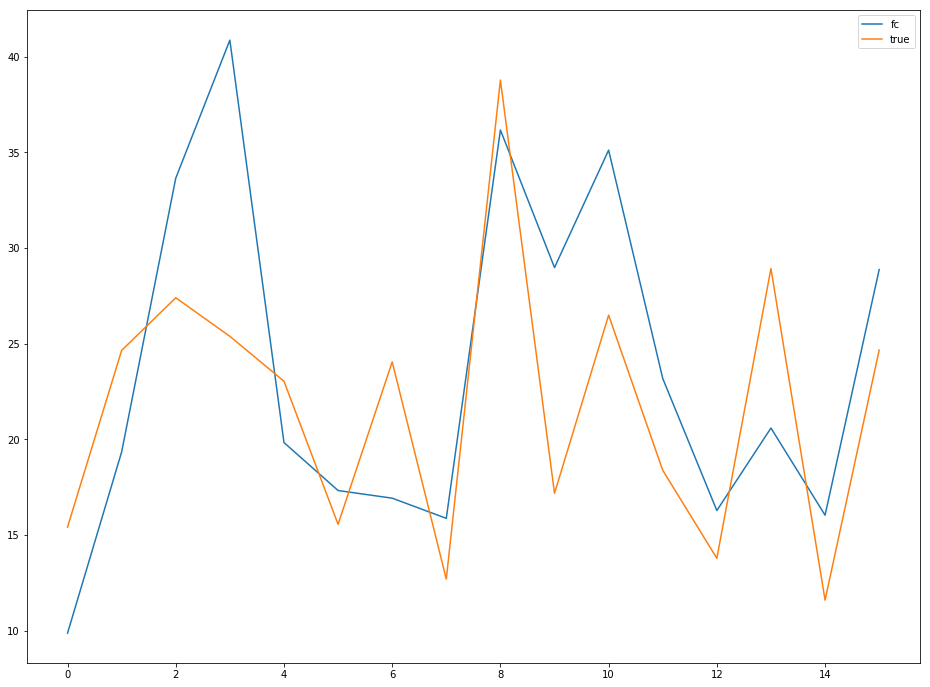

In [6]:
plt.figure(figsize = (16,12))
plt.plot(y_pred, label = 'fc')
plt.plot(y_true, label = 'true')
plt.legend()
plt.show()